In [1]:
%%capture
%env GEOMSTATS_BACKEND=autograd

import sys
!{sys.executable} -m pip install geomstats autograd ipywidgets

from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.learning.geodesic_regression import GeodesicRegression
import geomstats.backend as gs

# ln 266 in pre_shape.py -> add full_matrices=False to svd call (otherwise autodiff will fail)
# from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
from pre_shape_autodiff import PreShapeSpace, KendallShapeMetric

from sasaki_metric import SasakiMetric

from util import visSphere, visKen, visKenGeo, visTPCA, load_data, initial_mean

# time points sampled to visualize geodesics
t = gs.linspace(0, 1, 25)

# Sasaki Metric and Applications in Geodesic Analysis

Authors: Felix Ambellan, Martin Hanik, Dr. Esfandiar Nava-Yazdani, and Dr. Christoph von Tycowicz

## 1. Introduction and motivation
An important problem in statistics is the analysis of longitudinal data, which is collected, most prominently, in many medical studies. Thereby, one _repeatedly_ observes the same individuals to collect changes that might occur over a period of time. Such data poses challenges because fundamental independency assumptions, which many statistical procedures presuppose, are violated: While it is often reasonable to assume that observations from different individuals are independent, this is quite certainly wrong when they come from the same subject---especially when not too much time passed between them.
Much research has focussed on the correct analysis of multivariate longitudinal data, and, in recent years, several of the resulting methods have been generalized to manifold-valued longitudinal data with success.

Amongst others, _hierarchical models_ that rely on geodesics were formulated. They split the analysis of (local-enough) data up into the following two consecutive steps:

 * In the first step, each subject's trend is captured independently via geodesic regression. Thereby, correlated samples are dealt with exclusively.
 * In the second step, group-wise analysis (e.g., computation of a mean geodesic, covariance analysis of trends) of the subject-specific geodesics can be performed with standard (Riemannain geometric) tools, because the computed trends are (usually) independent again.

In order to perform statistical analysis of geodesics, we need to turn the ''space of geodesics'' into a Riemannian manifold. This can be done as follows: Let $M$ be the underlying Riemannian manifold (the manifold in which the data lies), $g$ its metric, and $TM$ its tangent bundle. Further, let $\gamma: [0,1] \to M$ be a geodesic. Because $\gamma$ is uniquely determined by its starting point and initial velocity, i.e., by an element $(p,v) \in TM$, we can _identify_ it with the latter element of $TM$. In other words, we can identify the space of geodesics with (a part of) the tangent bundle.

Now, it is a well-known fact that the tangent bundle $TM$ of a smooth Riemannian manifold is also a smooth manifold. As such it can be endowed with a Riemannian structure. A very natural choice of metric (which is now defined on $TTM$) is the _Sasaki metric_ named after its discoverer [Shigeo Sasaki](https://mathshistory.st-andrews.ac.uk/Biographies/Sasaki/); it is characterized by the following three properties:

* the projection $\pi$ of $TM$ onto $M$ given by $(p,v) \mapsto p$ is a [Riemannian submersion](https://en.wikipedia.org/wiki/Riemannian_submersion),
* tangent vectors of parallel vector fields $X(t)$ along curves $p(t)$ in $M$ (which, as $t \mapsto (p(t), X(t))$, are curves in $TM$) are orthogonal to fibres (i.e., to tangent vectors of curves $t \mapsto (p, Y(t)) \in TM$ with fixed footpoint),
* its restriction to any tangent space $T_pM \subset TM$ is the Euclidean metric introduced there by $g$.

This metric (together with its corresponding Levi-Civita connection) can be used for statistics in $TM$ and, thus, in the second step of the hierarchical model outlined above; this was first proposed by Muralidharan and Fletcher (see the reference below).

Moreover, apart from the particular application of longitudinal data analysis with geodesics, the Sasaki metric can be very useful for any type of statistics whenever we measure data that lies in the tangent bundle of some manifold $M$.

We implemented the Sasaki metric using _geomstats_ for this challenge.
Notice that in order to compute quantities like the Fréchet mean of points in $TM$ w.r.t. the Sasaki metric, we must evaluate the corresponding exponential and logarithm. No closed-form solution is known, but Muralidharan and Fletcher proposed discrete formulations of the geodesic equation on $TM$.

This tutorial shows (after an introductory example on the 2-sphere) its application in the analysis of longitudinal shape data of rat skulls, following the hierarchical modelling procedure outlined above.

---

Literature on the Sasaki metric and on hierarchical geodesic models are, e.g., the following:

* [On the Differential Geometry of Tangent Bundles of Riemannian Manifolds II](https://doi.org/10.2748/tmj/1178244169)
* [A Hierarchical Geodesic Model for Longitudinal Analysis on Manifolds](https://doi.org/10.1007/s10851-022-01079-x)
* [Sasaki Metrics for Analysis of Longitudinal Data on Manifolds](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4270017)

## 2. Illustration: Shortest paths and mean of geodesics on the 2-sphere

As mentioned above, geodesics can be identified with elements of the tangent bundle. Hence, the Sasaki metric can be used to measure distances between them and, therefore, to compute the _shortest path between two geodesics_. Note that the latter is a geodesic in $TM$. We give an example on the 2-sphere $S^2$. First, we initialize the manifold and the Sasaki metric; and we create two points in $TS^2$.


In [2]:
S2 = Hypersphere(dim=2)
S2_metric = S2.metric
# Fix: #shape property of HypersphereMetric not initialized consistently
if S2.default_coords_type == 'extrinsic':
    S2_metric.shape = (S2.dim+1,)
sas = SasakiMetric(S2.metric)

p0, u0 = gs.array([0., -1, 0]), gs.array([1., 0, 1])
pu0 = gs.array([p0, u0])
pL, uL = gs.array([1., 0, 0]), gs.array([0., 1, 1])
puL = gs.array([pL, uL])

Then, we calculate the shortest path between the two points (red) and visualize it. To this end we use the identification of elements of $TS^2$ and geodesics in $S^2$; thereby, a curve in $TS^2$ corresponds to a family of geodesics (blue) in $S^2$.

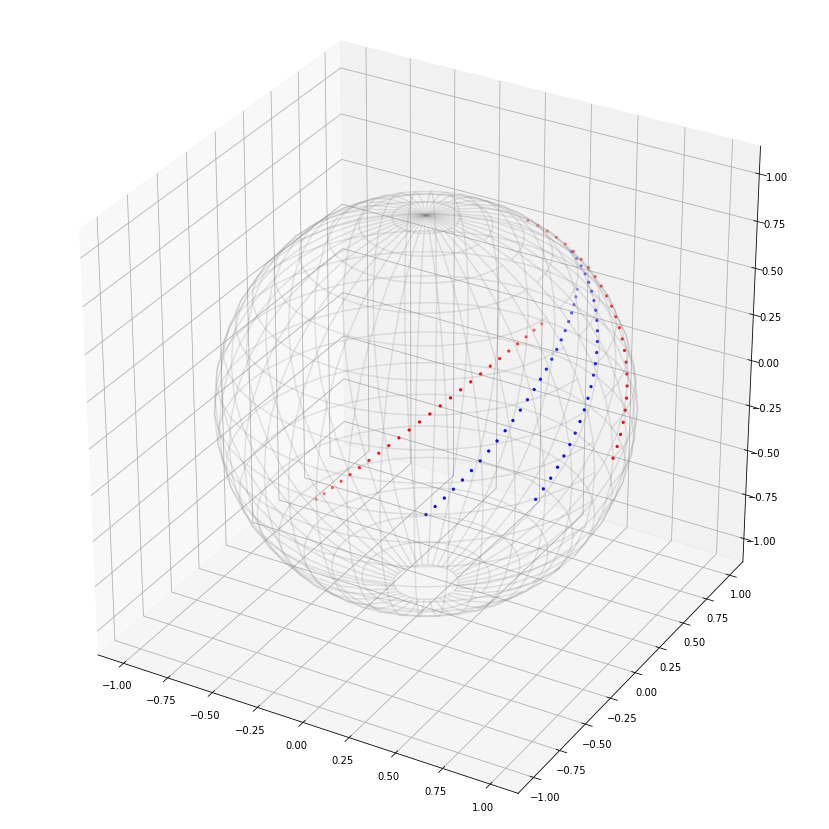

In [3]:
%matplotlib inline

# print('Computing shortest path of geodesics')
z = sas.geodesic_discrete(pu0, puL)
geo_list = []
geos0L, geos = [], []
geos0L.append(S2_metric.geodesic(p0, initial_tangent_vec=u0)(t))
geos0L.append(S2_metric.geodesic(pL, initial_tangent_vec=uL)(t))
geo_list = [geos0L]
for j in range(1, len(z) - 1):
    p1, u1 = z[j][0], z[j][1]
    geos.append(S2_metric.geodesic(p1, initial_tangent_vec=u1)(t))
geo_list += [geos]
visSphere(geo_list, ['r']+['b'])

Now we sample random geodesics using ```random_riemannian_normal``` and compute their (sample) Fréchet mean in $TM$. In the plot the data set is shown in red, while the mean geodesic is black; the mean of the underlying distribution is depicted in blue.

Computing mean of geodesics


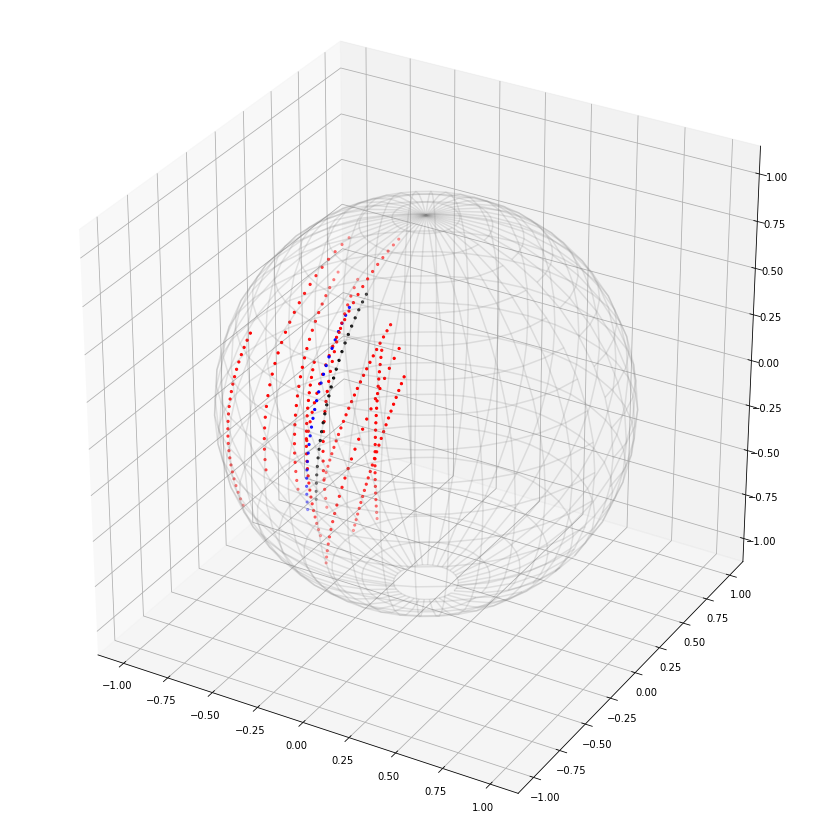

In [4]:
m = gs.array([[0, -1.0, 0], [0, 0, 1.0]])
n_samples, sigma = 10, gs.pi/12
x = S2.random_riemannian_normal(m[0], n_samples=n_samples)
y = S2.random_riemannian_normal(m[0], n_samples=n_samples)
x = [S2_metric.exp(sigma*S2_metric.log(x[i], m[0]), m[0]) for i in range(n_samples)]
u = [m[1] + sigma*S2_metric.log(y[i], m[0]) for i in range(n_samples)]
samples = gs.array([[x[i], u[i]] for i in range(n_samples)])

print('Computing mean of geodesics')
initial = initial_mean(samples, S2_metric)
mean_gs = FrechetMean(sas, init_point=initial)
mean_gs.fit(samples)
mean = mean_gs.estimate_

data, meanvalue, geom = [], [], []
meanvalue.append(S2_metric.geodesic(m[0], initial_tangent_vec=m[1])(t))
geom.append(S2_metric.geodesic(mean[0], initial_tangent_vec=mean[1])(t))
for sample in samples:
    data.append(S2_metric.geodesic(sample[0], initial_tangent_vec=sample[1])(t))
visSphere([data] + [meanvalue] + [geom], ['r'] + ['k'] + ['b'])

## 3. Application: Geodesic Analysis and Clustering via Regression in Kendall's Shape Space

We now show an application to real-world, longitudinal data. For this we use Vilmann’s rat calvaria (skulls excluding the lower jaw) which were obtained from X-ray images and analyze it using Kendall's shape space.
Each raw measurement consists of 8 landmarks in 2 dimensions; they were taken for 18 individuals at ages
of 7, 14, 21, 30, 40, 60, 90, and 150 days. The location of the landmarks and their labels can be seen in the figure below.

![rat](ratyz.png)

Clearly, we cannot expect that shapes from the same individual are independent. (But it is reasonable to assume that those of different subjects are.) Therefore, we analyze the data using a hierarchical model. We load the data, encode it in Kendall's shape space, and visualize the landmarks subject-wise (with time points overlaid).

In [5]:
%matplotlib notebook

# load rat calvaria shapes
samples = load_data()
samples_shape = samples.shape
# dataset contains 8 observations (landmark measurements) for each subject
n_samples, n_trj = samples_shape[0], 8
n_subjects, k_landmarks, dim = int(n_samples/n_trj), samples_shape[1], samples_shape[2]
print(f"Rat skulls data:{n_subjects} subjects observed at {n_trj} time points; each shape consisting of {k_landmarks} planar landmarks.")

# init Kendall shape space and metrics
Ken = PreShapeSpace(k_landmarks, dim)
KenMetric = KendallShapeMetric(k_landmarks, dim)
KenMetric.shape = Ken.shape # fix: shape not set consistently
sas = SasakiMetric(KenMetric)

# visualize shapes
samples = [Ken.projection(samples[i]) for i in range(n_samples)]
visKen(samples, ['#008c04'], size=8)

Rat skulls data:18 subjects observed at 8 time points; each shape consisting of 8 planar landmarks.


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='Subject', max=18), Output()), _dom_classes=('widget-inte…

We now perform the first step of the model: We employ geodesic regression to estimate the individual trends, (which we represent in the tangent bundle of Kendall's shape space).

In [6]:
samples = gs.reshape(gs.array(samples), (n_subjects, n_trj, k_landmarks, dim))
# 1st stage: Geodesic Regression
reg = GeodesicRegression(Ken, KenMetric, center_X=False, method="riemannian", initialization="warm_start")
# assume irregular time sampling to compensate for saturation in growth -> equidistant spread in shape space
x = gs.linspace(0., 1., n_trj)
geos = []
for trj in samples:
    # set warm start
    reg.intercept_ = trj[0]
    reg.coef_ = KenMetric.log(trj[-1], trj[0])
    # compute best fitting geodesic
    reg.fit(x, trj, compute_training_score=True)
    print('R^2:', reg.training_score_)
    p, u = reg.intercept_, reg.coef_
    geos.append(gs.reshape([p, u], sas.shape))
geos = gs.array(geos)

C:\Users\essi\PycharmProjects\venv\lib\site-packages\autograd\numpy\numpy_vjps.py:86: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.arccos, lambda ans, x : lambda g:-g / anp.sqrt(1 - x**2))


R^2: 0.9394696083870757
R^2: 0.9068142324737499
R^2: 0.9303710965712144
R^2: 0.8868197952476633
R^2: 0.8460832590136212
R^2: 0.9412962527118096
R^2: 0.941444903159311
R^2: 0.927102553410261
R^2: 0.8699867951348357
R^2: 0.8660799667248997
R^2: 0.9100275955477325
R^2: 0.8995291192893354
R^2: 0.9271392960316902
R^2: 0.892623328781743
R^2: 0.8621010718639049
R^2: 0.90823669787917
R^2: 0.9010065739527637
R^2: 0.8728034314901851


Given the geodesic trends of each subject, we now proceed to the second stage of the hierarchical model and compute the mean of the individual geodesics. We visualize all trajectories landmark-wise in the following figure. While the subject trajectories are depicted in red, their mean is depicted in black.

In [ ]:
# group mean
initial = initial_mean(gs.reshape(geos, (-1, 2) + Ken.shape), sas.metric)
mean_gs = FrechetMean(sas, init_point=gs.reshape(initial, sas.shape))
mean_gs.fit(geos)
mean = gs.reshape(mean_gs.estimate_, (2, *Ken.shape))
# visualize
visKenGeo(gs.reshape(geos, (-1, 2, *Ken.shape)), mean)

Finally, we apply tangent PCA to the geodesics and visualize the results. This allows us to access the variability of the trends around the mean. Furthermore, we can utilize the principal components to perform a change of basis on the data. In particular, using only the first few principal components and ignoring the rest yields a low dimensional representation that is amenable to tasks such as visualization or classification.

<IPython.core.display.Javascript object>


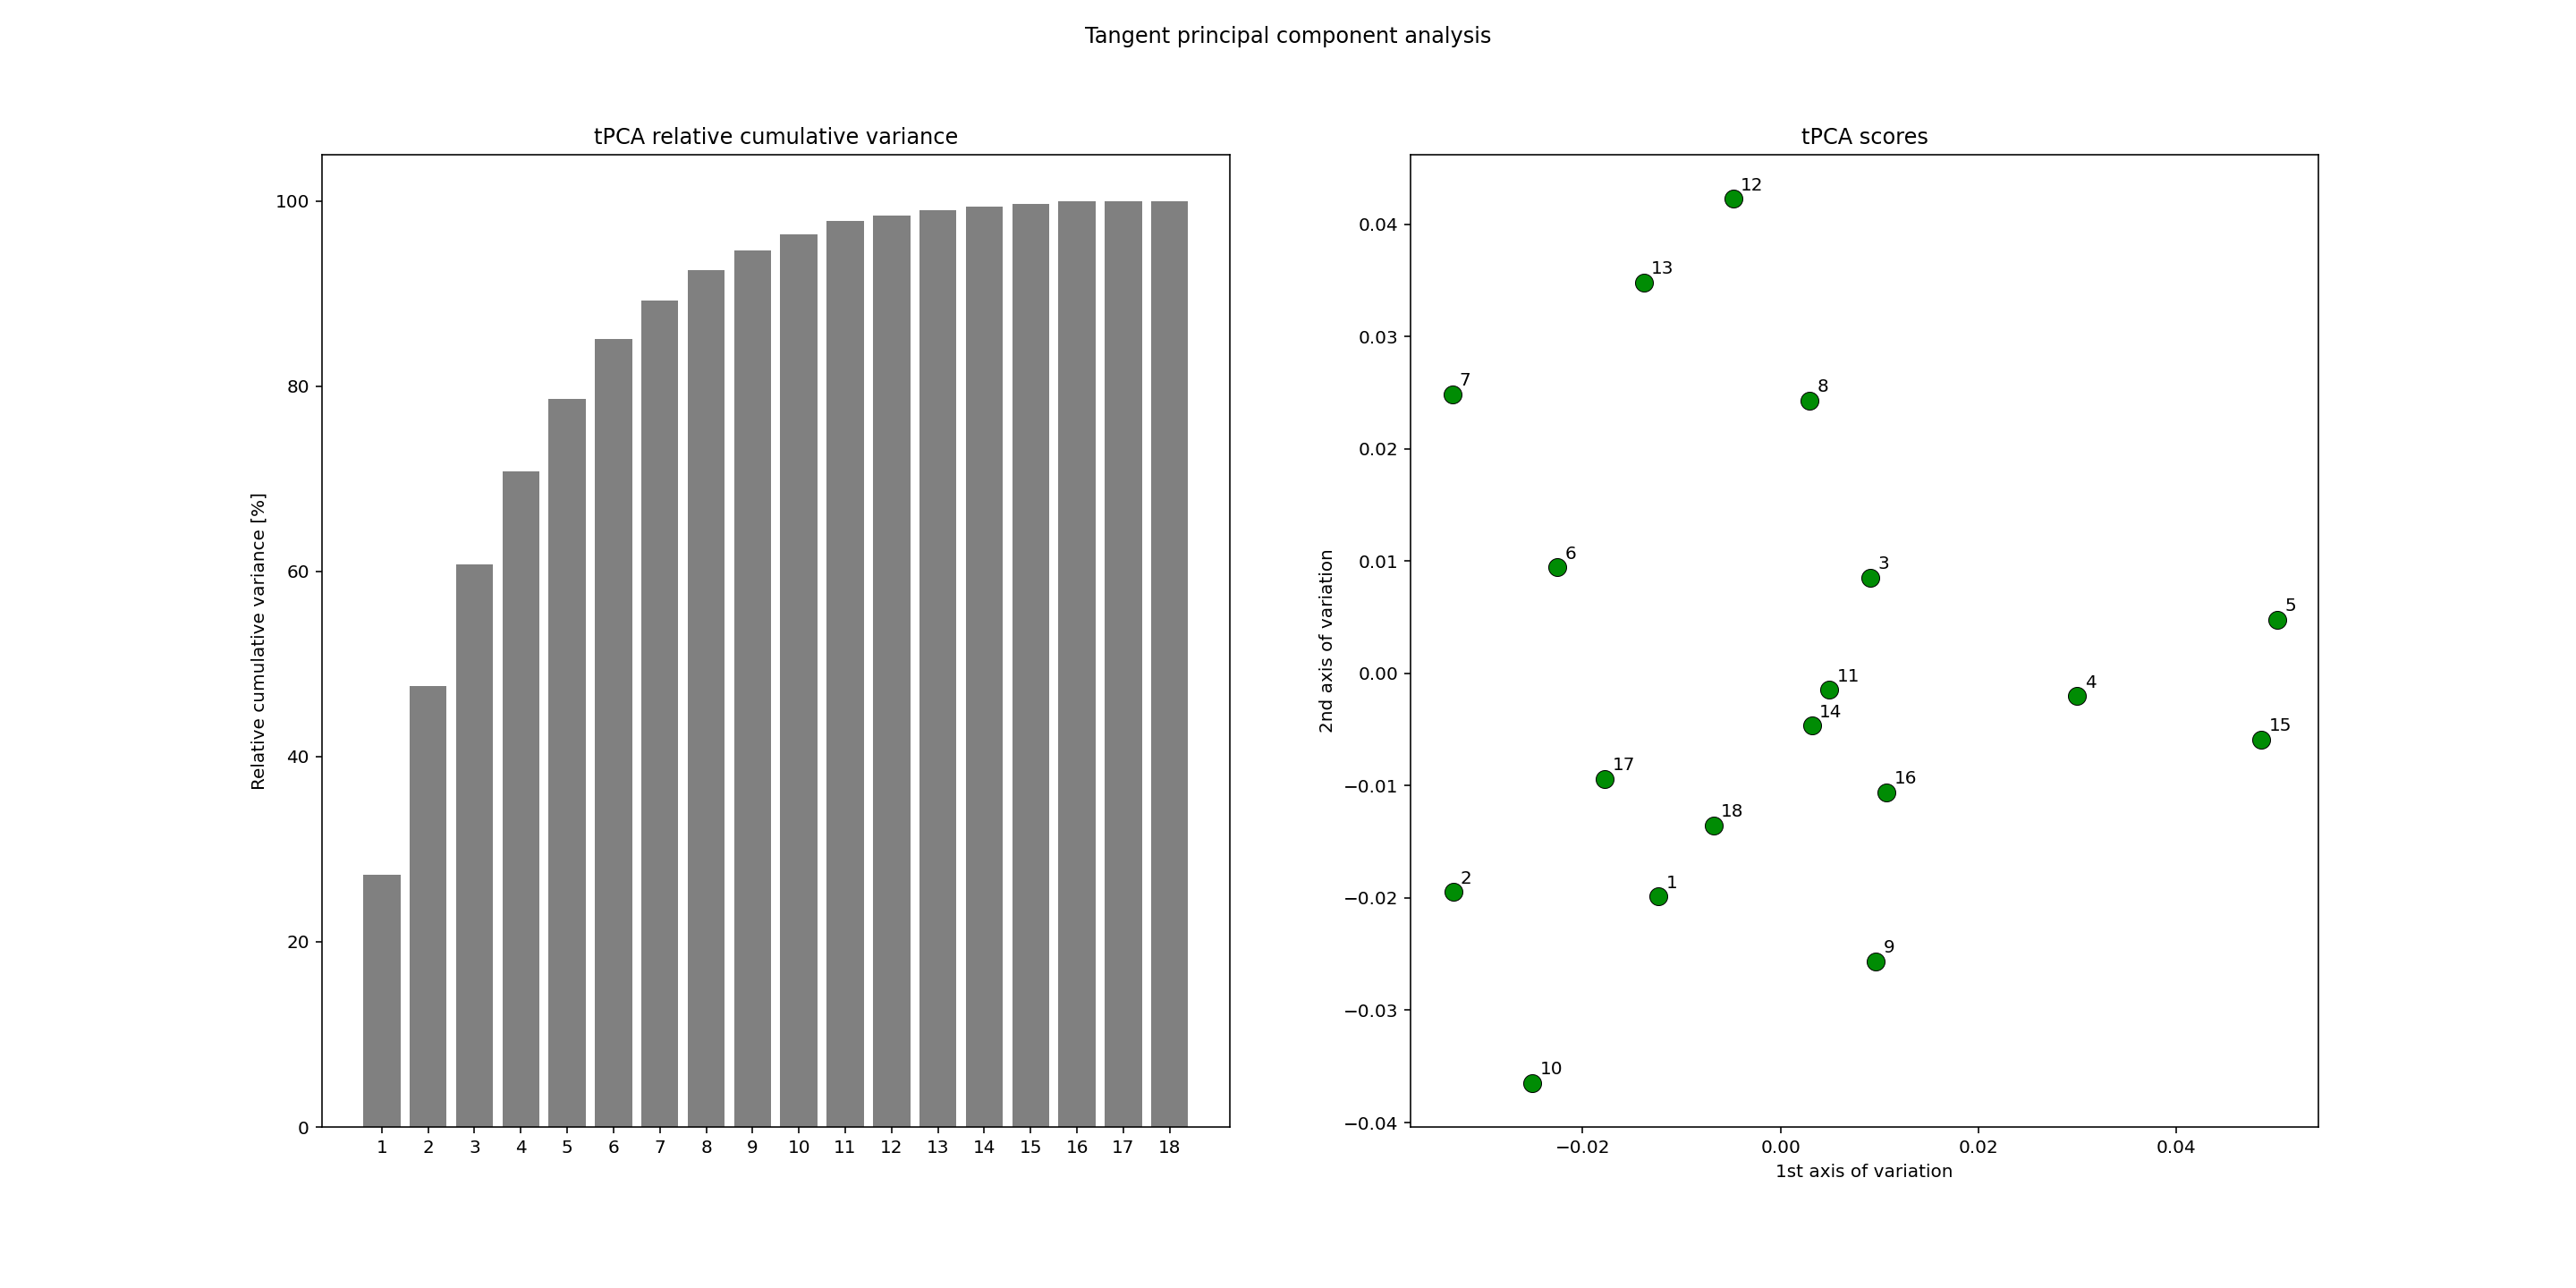

In [8]:
# Tangent PCA
tpca = TangentPCA(metric=sas)
geos_proj = tpca.fit_transform(geos, base_point=mean_gs.estimate_)
# visualize tangent PCA
visTPCA(tpca.explained_variance_, geos_proj)

## 4. Conclusion

We present an implementation of the Sasaki metric that is native to the geomstats library, i.e. it is:
* a proper subclass of ```RiemannianMetric```,
* generic to the tangent bundle $TM$ of any base manifold $M$ in geomstats (depending solely on a Riemannian metric on $M$),
* integrates with statistical learning tools from geomstats, and
* compatible with multiple backends via ```gs.```.

Obtain a hierarchical geodesic model for longitudinal data on manifolds, i.e.:
* estimate subject-wise geodesic trends via ```GeodesicRegression``` in Kendall's shape space $\Sigma$,
* perform first and second moment analysis on $T\Sigma$ using ```FrechetMean``` and ```TangentPCA``` by virtue of our new ```SasakiMetric``` parametrized by ```KendallShapeMetric```, and
* investigate the spatiotemporal variability in longitudinal shape data of rat calvaria.